In [1]:
from skimage.io import ImageCollection, imread
from skimage.transform import resize
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
from torch.nn import BCEWithLogitsLoss
from torchvision import transforms, datasets, models
from torchvision.transforms import Lambda
from fastai.data.core import DataLoaders
from fastai.vision.all import *
from pyxtend import struct
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

## Rebuilding the file_paths list to continue pre-processing.

In [2]:
parent_directory = '/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms'

subdirectories = [subdir for subdir in os.listdir(parent_directory) if os.path.isdir(os.path.join(parent_directory, subdir)) and not subdir.startswith(".")]

# List to store the image file paths
file_paths = []

for subdirectory in subdirectories:
    # Construct the folder path
    subdirectory_path = os.path.join(parent_directory, subdirectory)
    
    # Get the image file paths in the subdirectory
    image_files = [os.path.join(subdirectory_path, file) for file in os.listdir(subdirectory_path) if file.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Extend the file_paths list with the image file paths
    file_paths.extend(image_files)

# Print the number of images loaded
print(f"Number of images loaded into file_paths: {len(file_paths)}")

image_paths = [Path(path) for path in file_paths]

Number of images loaded into file_paths: 3400


In [3]:
labels = []
for file_path in file_paths:
    filename = os.path.basename(file_path)
    if filename.startswith("edible"):
        labels.append("edible")
    elif filename.startswith("poisonous"):
        labels.append("poisonous")
    else:
        labels.append("unknown")

print("Size of label folder: ", len(labels))
print("Unique entries: ", set(labels))

Size of label folder:  3400
Unique entries:  {'edible', 'poisonous'}


In [4]:
extensions = set()

for file_path in file_paths:
    extension = file_path.split('.')[-1]  # Extract the file extension
    extensions.add(extension)

print("Unique Extensions:", extensions)

Unique Extensions: {'jpg'}


## Creating the FastAi DataLoaders from my data.

In [5]:
# Making dataframe of from file_paths, labels
data = list(zip(file_paths, labels))
df = pd.DataFrame(data, columns=['col_1', 'col_2'])

# First, we split the data into training+validation set and test set.
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

#verifying the number of file path & label pairs in data.  Also looking at the first five entries.
print(len(train_val_df))

2720


In [6]:
train_val_df.head()

,col_1,col_2
3392,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/edible_sporocarp/edible_sporocarp (191).jpg,edible
2167,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/poisonous_sporocarp/poisonous_sporocarp (1280).jpg,poisonous
3066,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/edible_sporocarp/edible_sporocarp (462).jpg,edible
2387,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/poisonous_sporocarp/poisonous_sporocarp (28).jpg,poisonous
2905,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/poisonous_sporocarp/poisonous_sporocarp (1271).jpg,poisonous


In [7]:
# Define function to get image file paths
def get_x(row):
    return row['col_1']

# Define function to get labels
def get_y(row):
    return row['col_2']

# Creating a DataBlock
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=40),
                   item_tfms=Resize(128))

# Create a DataLoaders object using the DataBlock
dls = dblock.dataloaders(train_val_df)

In [8]:
if len(dls) > 0:
    print("DataLoaders object is not empty.")
else:
    print("DataLoaders object is empty.")

print("DataLoaders contains", len(dls), "instances.")

DataLoaders object is not empty.
DataLoaders contains 2 instances.


In [9]:
print(len(dls.train))
print(len(dls.valid))

34
9


## Training the model on my FastAi DataLoaders object.

/Users/maxwellkreitman/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxwellkreitman/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,precision_score,recall_score,time
0,1.034712,1.706136,0.694165,[0.15083799 0.94520548],00:17
1,0.784716,0.690517,0.863946,[0.77653631 0.69589041],00:18
2,0.637967,0.564080,0.833803,[0.67039106 0.8109589 ],00:17
3,0.494150,0.543230,0.825000,[0.64804469 0.81369863],00:17


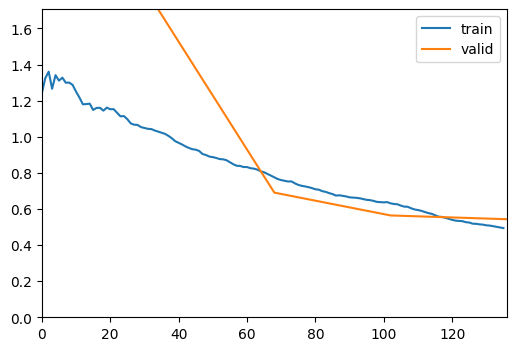

(#3) [0.5432303547859192,0.825,array([0.64804469, 0.81369863])]

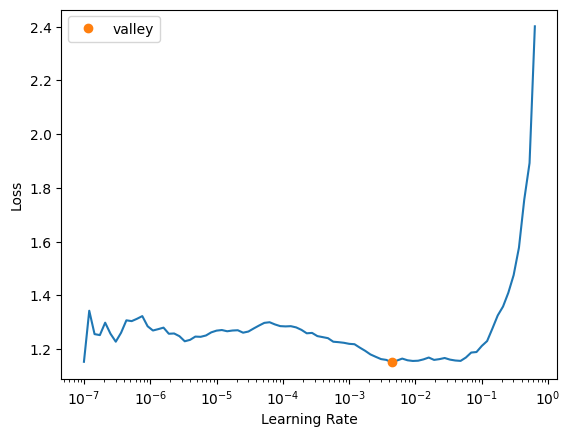

In [10]:

# Creating a model
model = vision_learner(dls, resnet34, metrics=[Precision(), Recall(average=None)], cbs=ShowGraphCallback())

# Finding the optimal learning rate
model.lr_find()

# Training the model
model.fit_one_cycle(4, 1e-2)

# Evaluating the model on the validation set
model.validate()

## Moving onto predictions with the test set.

In [11]:
test_df.head()

,col_1,col_2
291,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/edible_mushroom_sporocarp/edible_mushroom_sporocarp (368).jpg,edible
755,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/poisonous_mushroom_sporocarp/poisonous_mushroom_sporocarp (293).jpg,poisonous
2096,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/poisonous_sporocarp/poisonous_sporocarp (660).jpg,poisonous
432,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/edible_mushroom_sporocarp/edible_mushroom_sporocarp (428).jpg,edible
479,/Users/maxwellkreitman/Desktop/Springboard/Capstone Three/Mushrooms/edible_mushroom_sporocarp/edible_mushroom_sporocarp (281).jpg,edible


In [12]:
#Creating a dataloader from test df
test_dl = dls.test_dl(test_df)

#Gathering predictions
predictions, _ = model.get_preds(dl=test_dl)

In [13]:
#Building a tensor with the predicted classes for each instance in your test set.
predicted_classes = predictions.argmax(dim=1)

In [14]:
#Building a tensor with the encoded labels of test_df
actual_classes = torch.tensor([dls.vocab.o2i[label] for label in test_df['col_2']])

In [15]:
# Calculate precision and recall
precision = precision_score(actual_classes, predicted_classes, average=None)
recall = recall_score(actual_classes, predicted_classes, average=None)

print("The order of values in the precision and recall returns is:", dls.vocab)
print("Precision: ", precision)
print("Recall: ", recall)


#Calculating accuracy of model with test_df
accuracy = (predicted_classes == actual_classes).float().mean()
print(f'Accuracy: {accuracy}')

The order of values in the precision and recall returns is: ['edible', 'poisonous']
Precision:  [0.73109244 0.80316742]
Recall:  [0.66666667 0.84725537]
Accuracy: 0.7779411673545837


## It's most important for human safetly to correctly identify what's poisonous.  Look to the second value in the precision and recall calculations.


## The precision of poisonous mushrooms tells us that the model was successful 79% of the time over all its predicitions of poisonous mushrooms. 21% of the model's predictions for poisonous mushrooms were actually edible.

## The recall of poisonous mushrooms tells us that the model's poisonous mushroom predicitions covered 82.5% of all actual poisonous mushrooms.

## Now I'm interested in improving the model by tring out larger image resizing first, then different pre-trained model from torchvision with more layers.

In [16]:
# Define function to get image file paths
def get_x(row):
    return row['col_1']

# Define function to get labels
def get_y(row):
    return row['col_2']

# Creating a DataBlock
dblock2 = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=40),
                   item_tfms=Resize(224)) #Changed from 128 pixels to 224 pixels

# Create a DataLoaders object using the DataBlock
dls_2 = dblock2.dataloaders(train_val_df)

/Users/maxwellkreitman/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxwellkreitman/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,precision_score,recall_score,time
0,1.002490,0.895864,0.746377,[0.41340782 0.84657534],00:35
1,0.777751,0.536440,0.795970,[0.54748603 0.86575342],00:37
2,0.601333,0.447965,0.834211,[0.64804469 0.86849315],03:40
3,0.448319,0.429897,0.871148,[0.74301676 0.85205479],00:35


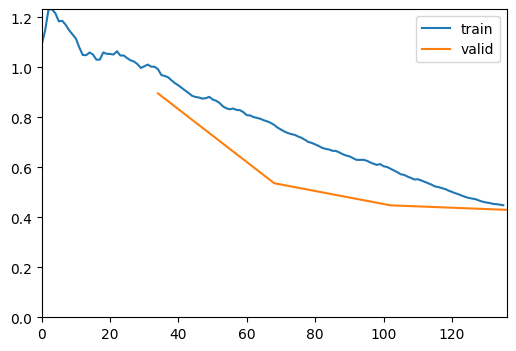

(#3) [0.429897278547287,0.8711484593837535,array([0.74301676, 0.85205479])]

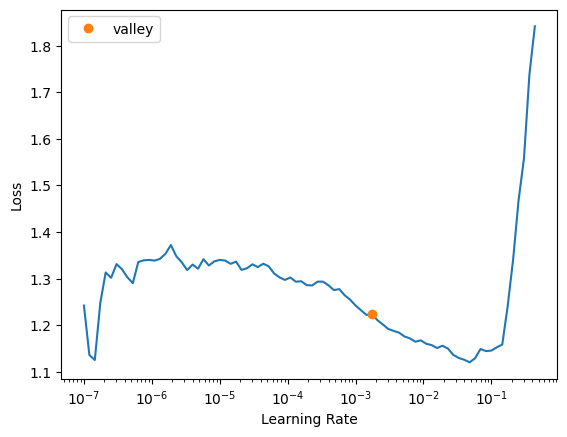

In [17]:
# Creating a model
model_2 = vision_learner(dls_2, resnet34, metrics=[Precision(), Recall(average=None)], cbs=ShowGraphCallback())

# Finding the optimal learning rate
model_2.lr_find()

# Training the model
model_2.fit_one_cycle(4, 1e-2)

# Evaluating the model on the validation set
model_2.validate()

In [18]:
#Creating a dataloader from test df
test_dl_2 = dls_2.test_dl(test_df)

predictions, _ = model_2.get_preds(dl=test_dl_2)
predicted_classes = predictions.argmax(dim=1)
actual_classes = torch.tensor([dls_2.vocab.o2i[label] for label in test_df['col_2']])

# Calculate precision and recall
precision_2 = precision_score(actual_classes, predicted_classes, average=None)
recall_2 = recall_score(actual_classes, predicted_classes, average=None)

print("The order of values in the precision and recall returns is:", dls_2.vocab)
print("Precision: ", precision_2)
print("Recall: ", recall_2)

#Calculating accuracy of model with test_df
accuracy = (predicted_classes == actual_classes).float().mean()
print(f'Accuracy: {accuracy}')

The order of values in the precision and recall returns is: ['edible', 'poisonous']
Precision:  [0.74008811 0.79470199]
Recall:  [0.64367816 0.85918854]
Accuracy: 0.7764706015586853


## The increase in image size resulted in slightly improved recall of both classes.

## Now let's try a resnet pre-trained model with 50 layers with the original dataloader "dls" with image resize of 128 pixels.

/Users/maxwellkreitman/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/maxwellkreitman/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,precision_score,recall_score,time
0,1.042761,1.005499,0.713684,[0.24022346 0.92876712],00:27
1,0.765568,0.629498,0.746606,[0.37430168 0.90410959],00:27
2,0.594200,0.478642,0.833780,[0.65363128 0.85205479],00:26
3,0.435454,0.466091,0.845304,[0.68715084 0.83835616],00:27


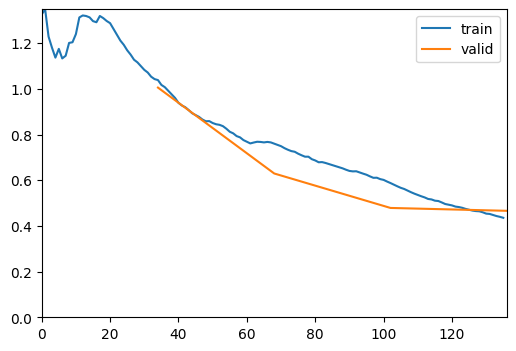

(#3) [0.46609050035476685,0.8453038674033149,array([0.68715084, 0.83835616])]

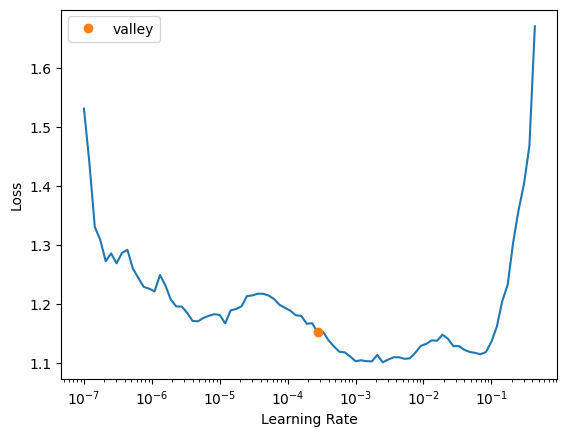

In [19]:
# Creating a model
model_3 = vision_learner(dls, resnet50, metrics=[Precision(), Recall(average=None)], cbs=ShowGraphCallback())

# Finding the optimal learning rate
model_3.lr_find()

# Training the model
model_3.fit_one_cycle(4, 1e-2)

# Evaluating the model on the validation set
model_3.validate()

In [20]:
#Creating a dataloader from test df
test_dl_3 = dls.test_dl(test_df)

predictions, _ = model_3.get_preds(dl=test_dl_3)
predicted_classes = predictions.argmax(dim=1)
actual_classes = torch.tensor([dls.vocab.o2i[label] for label in test_df['col_2']])

# Calculate precision and recall
precision_3 = precision_score(actual_classes, predicted_classes, average=None)
recall_3 = recall_score(actual_classes, predicted_classes, average=None)

print("The order of values in the precision and recall returns is:", dls.vocab)
print("Precision: ", precision_3)
print("Recall: ", recall_3)

#Calculating accuracy of model with test_df
accuracy = (predicted_classes == actual_classes).float().mean()
print(f'Accuracy: {accuracy}')

The order of values in the precision and recall returns is: ['edible', 'poisonous']
Precision:  [0.712      0.80697674]
Recall:  [0.68199234 0.82816229]
Accuracy: 0.7720588445663452


## Improved precision and recall!

## When I tried to combine pre-trained 50 layer model with increased image size, the operating timed out after many hours of waiting.

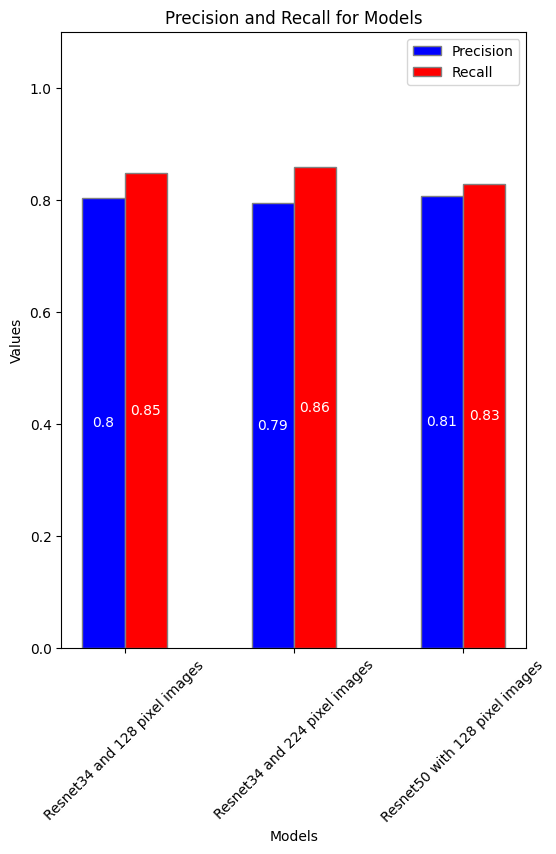

In [34]:
categories = ['Resnet34 and 128 pixel images', 'Resnet34 and 224 pixel images', 'Resnet50 with 128 pixel images']

# Precision and recall values for each category
precision_values = [precision[1], precision_2[1], precision_3[1]]
recall_values = [recall[1], recall_2[1], recall_3[1]]


r1 = np.arange(len(precision_values))
r2 = [x + 0.25 for x in r1]  # 0.25 represents the width of the bars

plt.figure(figsize=(6, 8))

# Creating the vertical bars
bars1 = plt.bar(r1, precision_values, color='b', edgecolor='grey', width=0.25, label='Precision')
bars2 = plt.bar(r2, recall_values, color='r', edgecolor='grey', width=0.25, label='Recall')

# Adding labels and title
plt.xlabel("Models")
plt.xticks([r + 0.125 for r in range(len(precision_values))], categories)  # Positioning the x-labels in the middle of the bars
plt.xticks(rotation=45)
plt.ylabel("Values")
plt.ylim([0, 1.1])
plt.title("Precision and Recall for Models")


# Label with bar's height
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, round(yval, 2), va='center', ha='center', color='white')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, round(yval, 2), va='center', ha='center', color='white')

plt.legend()

plt.show()





## If our goal is to have the best success over predicitions of poisonous mushrooms, the model with Resnet50 and 128 pixel images performed best with 81%.

## If our goal is to have the most coverage of correct predictions of poisonous mushrooms, the model with Resnet34 and 224 pixel images performed best with 86%.

## Let's look at their confusion matrices.

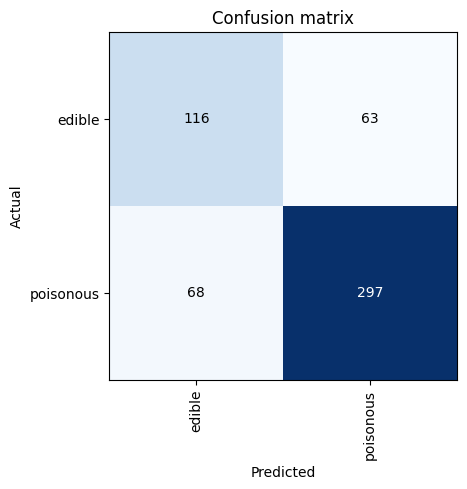

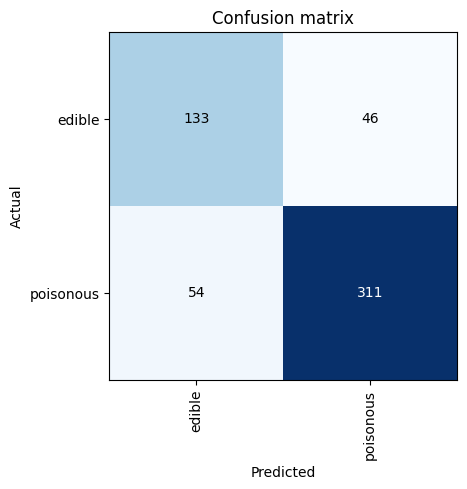

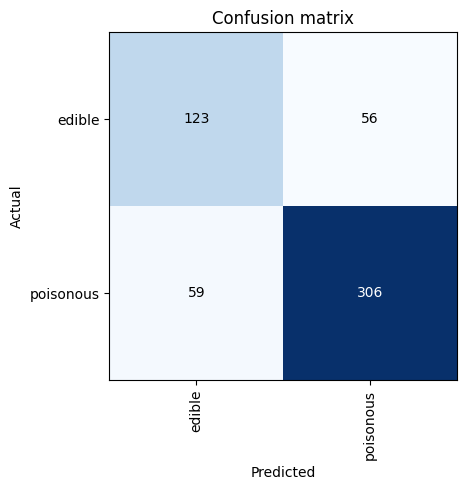

In [37]:
interp = ClassificationInterpretation.from_learner(model)
interp_2 = ClassificationInterpretation.from_learner(model_2)
interp_3 = ClassificationInterpretation.from_learner(model_3)
# Plotting the confusion matrix
interp.plot_confusion_matrix()
interp_2.plot_confusion_matrix()
interp_3.plot_confusion_matrix()

## The clear winner here is the second model, using Resnet34 and 224 image pixels.  This model also had the highest recall score for the poisonous mushroom class.